**Imports**

In [4]:
import random
import math
import networkx as nx  # Permite trabajar con grafos
import pgmpy.models as pgmm  # Modelos gráficos de probabilidad

**Generador del tablero**

La clase *Board* genera un tablero de casillas dados los siguientes parámetros de entrada:

    - width: Anchura del tablero (número de casillas).
    - height: Altura del tablero (número de casillas).
    - num_mines: Número de minas que contiene el tablero.

In [128]:
class Square():
    
    def __init__(self, mine = False, neighbor_mines = 0, hidden = True):
        self.is_mine        = mine
        self.neighbor_mines = neighbor_mines
        self.is_hidden      = hidden
        
    def reveal(self):
        self.is_hidden = False
        
    def set_mine(self):
        self.is_mine = True
        
    def inc_neighbor_mines(self):
        self.neighbor_mines += 1

In [139]:
# TODO: Attributes and functions non-public

class Board():
    
    NEIGHBOR_COORDS = (
        (-1, 1), (0, 1), (1, 1),
        (-1, 0),         (1, 0),
        (-1,-1), (0,-1), (1,-1)
    )
    
    def __init__(self, width, height, num_mines):
        self.size_x = width
        self.size_y = height
        self.squares = [[Square() for y in range(self.size_y)] for x in range(self.size_x)]
        
        self.place_mines(num_mines)
    
    def place_mines(self, num_mines):
        mines = random.sample(range(self.size_x * self.size_y), num_mines)
        for i in mines:
            mine_coords = self.get_coordinates(i)
            x = mine_coords[0]
            y = mine_coords[1]
            square = self.squares[x][y]
            square.set_mine()
            
            self.update_neighbors(x, y)
            
    # Example with 3x3 board:
    #     - Mine 0 (mine = 0) belong to the coordinates (0,2). Top-left corner.
    #     - Mine 8 (mine = 8) belong to the coordinates (2,0). Bottom-right corner.
    def get_coordinates(self, mine):
        y = math.floor(mine/self.size_x)
        x = mine - self.size_x*y
        return (x, y)
    
    def update_neighbors(self, coord_x, coord_y):
        for i in range(8):
            x = coord_x + self.NEIGHBOR_COORDS[i][0]
            y = coord_y + self.NEIGHBOR_COORDS[i][1]
            if not (self.invalid_coords(x, y)):
                neighbor = self.squares[x][y]
                neighbor.inc_neighbor_mines()
                
    def invalid_coords(self, coord_x, coord_y):
        return (coord_x < 0 
                or coord_x >= self.size_x 
                or coord_y < 0 
                or coord_y >= self.size_y
        )
    
    # Defined for debugging
    def print_revealed(self):
        res = ''
        
        for y in range(self.size_y):
            for x in range(self.size_x):
                square = self.squares[x][y]
                res += '* ' if square.is_mine else '{} '.format(square.neighbor_mines)
            res += '\n'
        
        return res

#    This function only reveals the selected square. Need to implement a
#    recursive algorithm to reveal contiguous squares without mines.
#
#    def reveal(self, coord_x, coord_y):
#        square = self.squares[coord_x][coord_y]
#        if square.is_mine:
#            print('GAME OVER\n=================')
#            print(self.print_revealed())
#        else:
#            square.reveal()
#            print(self.__str__())
    
    def __str__(self):
        res = ''
        
        for y in range(self.size_y):
            for x in range(self.size_x):
                square = self.squares[x][y]
                res += '_ ' if square.is_hidden else '{} '.format(square.neighbor_mines)
            res += '\n'
        
        return res
        

Modelado de red bayesiana:

In [1]:
# Para definir la red bayesiana del juego Buscaminas, primero debemos construir el DAG
# Para ello, definimos los vértices y las aristas del grafo.

def generateDAG(n, m):            
    # Añadimos las aristas a la red bayesiana
    # Un vértice del tipo Yij tendrá una arista con otro vértice de la forma Xij si son colidantes
    # Por tanto, vamos a ir recorriendo cada una de las casillas del tablero y creando aristas que una
    # el vértice Y de esa casilla con los vértices X de las casillas colindantes.
    # Los vértices se crean automáticamente.
    DAG = nx.Graph()
    Modelo_Buscaminas = pgmm.BayesianModel()
    for i in range(1,n+1):
        for j in range(1,m+1):
            if i==1:
                if j==1:
                    # Independientemente del tamaño del tablero, el vértice Y11 siempre tiene los mismos vecinos:
                    Modelo_Buscaminas.add_edges_from([('Y11','X21'),
                                          ('Y11','X22'),
                                          ('Y11','X12')])
                    # El vértice Y1,m posee siempre los mismo vecinos: X1,m-1 y X2,m y X2,m-1:
                elif j==m:
                    Modelo_Buscaminas.add_edges_from([('Y1'+str(m),'X1'+str(m-1)),
                                          ('Y1'+str(m),'X2'+str(m)),
                                          ('Y1'+str(m),'X2'+str(m-1))])
                   # En esta rama se añaden las aristas correspondientes a los vértices donde j>1 && j<m:
                else:
                    Modelo_Buscaminas.add_edges_from([('Y1'+str(j),'X'+str(i)+str(j-1)),
                                          ('Y1'+str(j),'X'+str(i)+str(j+1)),
                                          ('Y1'+str(j),'X'+str(i+1)+str(j-1)),
                                          ('Y1'+str(j),'X'+str(i+1)+str(j)),
                                          ('Y1'+str(j),'X'+str(i+1)+str(j+1))])
            elif i==n:
                if j==1:
                    # El vértice Yn,1 posee 3 vecinos que son Xn,2, Xn-1,1 y Xn-1,2:
                    Modelo_Buscaminas.add_edges_from([('Y'+str(n)+str(1),'X'+str(n)+str(2)),
                                          ('Y'+str(n)+str(1),'X'+str(n-1)+str(1)),
                                          ('Y'+str(n)+str(1),'X'+str(n-1)+str(2))])
                   # El vértice Yn,m posee como vecinos los siguientes vértices: Xn,m-1, Xn-1,m y Xn-1,m-1:
                elif j==m:
                    Modelo_Buscaminas.add_edges_from([('Y'+str(n)+str(m),'X'+str(n)+str(m-1)),
                                          ('Y'+str(n)+str(m),'X'+str(n-1)+str(m)),
                                          ('Y'+str(n)+str(m),'X'+str(n-1)+str(m-1))])
                    # Los vecinos de los vértices Yi,j en los que j>1 y j<m son: Xn,j-1, Xn,j+1, Xn-1,j-1, Xn-1,j y Xn-1,j+1:
                else:
                    Modelo_Buscaminas.add_edges_from([('Y'+str(n)+str(j),'X'+str(n)+str(j-1)),
                                          ('Y'+str(n)+str(j),'X'+str(n)+str(j+1)),
                                          ('Y'+str(n)+str(j),'X'+str(n-1)+str(j-1)),
                                          ('Y'+str(n)+str(j),'X'+str(n-1)+str(j)),
                                          ('Y'+str(n)+str(j),'X'+str(n-1)+str(j+1))])
            # En esta rama, añadiremos las aristas de aquellos vértices Yi,j siendo i>1 && i<m. Dentro de esta rama
            # se estudiarán 3 situaciones distintas (3 subramas):
            else:
                # Subrama 1: se añaden las aristas para los vértices Yi,1 y sus correspondientes vecinos
                if j==1:
                    Modelo_Buscaminas.add_edges_from([('Y'+str(i)+str(1),'X'+str(i)+str(2)),
                                          ('Y'+str(i)+str(1),'X'+str(i+1)+str(1)),
                                          ('Y'+str(i)+str(1),'X'+str(i+1)+str(2)),
                                          ('Y'+str(i)+str(1),'X'+str(i-1)+str(1)),
                                          ('Y'+str(i)+str(1),'X'+str(i-1)+str(2))])
                # Subrama 2: se añaden las aristas para los vértices Yi,m y sus correspondientes vecinos
                elif j==m:
                    Modelo_Buscaminas.add_edges_from([('Y'+str(i)+str(m),'X'+str(i)+str(m-1)),
                                          ('Y'+str(i)+str(m),'X'+str(i+1)+str(m)),
                                          ('Y'+str(i)+str(m),'X'+str(i+1)+str(m-1)),
                                          ('Y'+str(i)+str(m),'X'+str(i-1)+str(m)),
                                          ('Y'+str(i)+str(m),'X'+str(i-1)+str(m-1))])
                # Subrama 3: se añaden las aristas para los vértices Yi,j donde 1<j<m y sus correspondientes vecinos
                else:
                    Modelo_Buscaminas.add_edges_from([('Y'+str(i)+str(j),'X'+str(i)+str(j+1)),
                                          ('Y'+str(i)+str(j),'X'+str(i)+str(j-1)),
                                          ('Y'+str(i)+str(j),'X'+str(i+1)+str(j-1)),
                                          ('Y'+str(i)+str(j),'X'+str(i+1)+str(j)),
                                          ('Y'+str(i)+str(j),'X'+str(i+1)+str(j+1)),
                                          ('Y'+str(i)+str(j),'X'+str(i-1)+str(j-1)),
                                          ('Y'+str(i)+str(j),'X'+str(i-1)+str(j)),
                                          ('Y'+str(i)+str(j),'X'+str(i-1)+str(j+1))])
                    
            DAG.add_nodes_from(Modelo_Buscaminas.nodes())
            DAG.add_edges_from(Modelo_Buscaminas.edges())
            
    return DAG

In [2]:
def drawDAG(DAG):
    nx.draw(DAG, with_labels=True, font_weight='bold')
    return True   

In [5]:
grafo = generateDAG(3, 3)

In [6]:
grafo.nodes()

NodeView(('Y11', 'X21', 'X22', 'X12', 'Y12', 'X11', 'X13', 'X23', 'Y13', 'Y21', 'X31', 'X32', 'Y22', 'X33', 'Y23', 'Y31', 'Y32', 'Y33'))

In [7]:
grafo.edges()

EdgeView([('Y11', 'X21'), ('Y11', 'X22'), ('Y11', 'X12'), ('X21', 'Y12'), ('X21', 'Y22'), ('X21', 'Y31'), ('X21', 'Y32'), ('X22', 'Y12'), ('X22', 'Y13'), ('X22', 'Y21'), ('X22', 'Y23'), ('X22', 'Y31'), ('X22', 'Y32'), ('X22', 'Y33'), ('X12', 'Y13'), ('X12', 'Y21'), ('X12', 'Y22'), ('X12', 'Y23'), ('Y12', 'X11'), ('Y12', 'X13'), ('Y12', 'X23'), ('X11', 'Y21'), ('X11', 'Y22'), ('X13', 'Y22'), ('X13', 'Y23'), ('X23', 'Y13'), ('X23', 'Y22'), ('X23', 'Y32'), ('X23', 'Y33'), ('Y21', 'X31'), ('Y21', 'X32'), ('X31', 'Y22'), ('X31', 'Y32'), ('X32', 'Y22'), ('X32', 'Y23'), ('X32', 'Y31'), ('X32', 'Y33'), ('Y22', 'X33'), ('X33', 'Y23'), ('X33', 'Y32')])

True

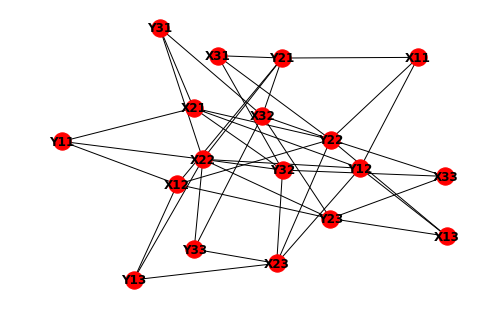

In [9]:
drawDAG(grafo)